In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, confusion_matrix

from metrics import *


warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
#read data
cc = pd.read_csv('data/processed_data.csv')
cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        7043 non-null   int64  
 1   customerid        7043 non-null   object 
 2   gender            7043 non-null   object 
 3   seniorcitizen     7043 non-null   int64  
 4   partner           7043 non-null   object 
 5   dependents        7043 non-null   object 
 6   tenure            7043 non-null   int64  
 7   phoneservice      7043 non-null   object 
 8   multiplelines     7043 non-null   object 
 9   internetservice   7043 non-null   object 
 10  onlinesecurity    7043 non-null   object 
 11  onlinebackup      7043 non-null   object 
 12  deviceprotection  7043 non-null   object 
 13  techsupport       7043 non-null   object 
 14  streamingtv       7043 non-null   object 
 15  streamingmovies   7043 non-null   object 
 16  contract          7043 non-null   object 


In [50]:
cc.isnull().sum()

Unnamed: 0          0
customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

Drop customerid columns because it does not add values to the analysis. Dropping will also reduce the dimensionality.

In [51]:
cc2 = cc.iloc[:,2:]
cc2.head(2)

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No


In [54]:
# replace churn values with 0 and 1
cc2.churn.replace({'Yes':1, 'No':0}, inplace=True)
cc2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   seniorcitizen     7043 non-null   int64  
 2   partner           7043 non-null   object 
 3   dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   phoneservice      7043 non-null   object 
 6   multiplelines     7043 non-null   object 
 7   internetservice   7043 non-null   object 
 8   onlinesecurity    7043 non-null   object 
 9   onlinebackup      7043 non-null   object 
 10  deviceprotection  7043 non-null   object 
 11  techsupport       7043 non-null   object 
 12  streamingtv       7043 non-null   object 
 13  streamingmovies   7043 non-null   object 
 14  contract          7043 non-null   object 
 15  paperlessbilling  7043 non-null   object 
 16  paymentmethod     7043 non-null   object 


In [53]:
# create pandas dummy variable for categorical features
dummy_cc = pd.get_dummies(cc2)
dummy_cc.to_csv('data/final_data.csv')
dummy_cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 46 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   seniorcitizen                            7043 non-null   int64  
 1   tenure                                   7043 non-null   int64  
 2   monthlycharges                           7043 non-null   float64
 3   totalcharges                             7043 non-null   float64
 4   churn                                    7043 non-null   int64  
 5   gender_Female                            7043 non-null   uint8  
 6   gender_Male                              7043 non-null   uint8  
 7   partner_No                               7043 non-null   uint8  
 8   partner_Yes                              7043 non-null   uint8  
 9   dependents_No                            7043 non-null   uint8  
 10  dependents_Yes                           7043 no

# <span style="color: green"> Visualizing Correlations

Plot correlations between target variable <b>Churn</b> with categorical features.

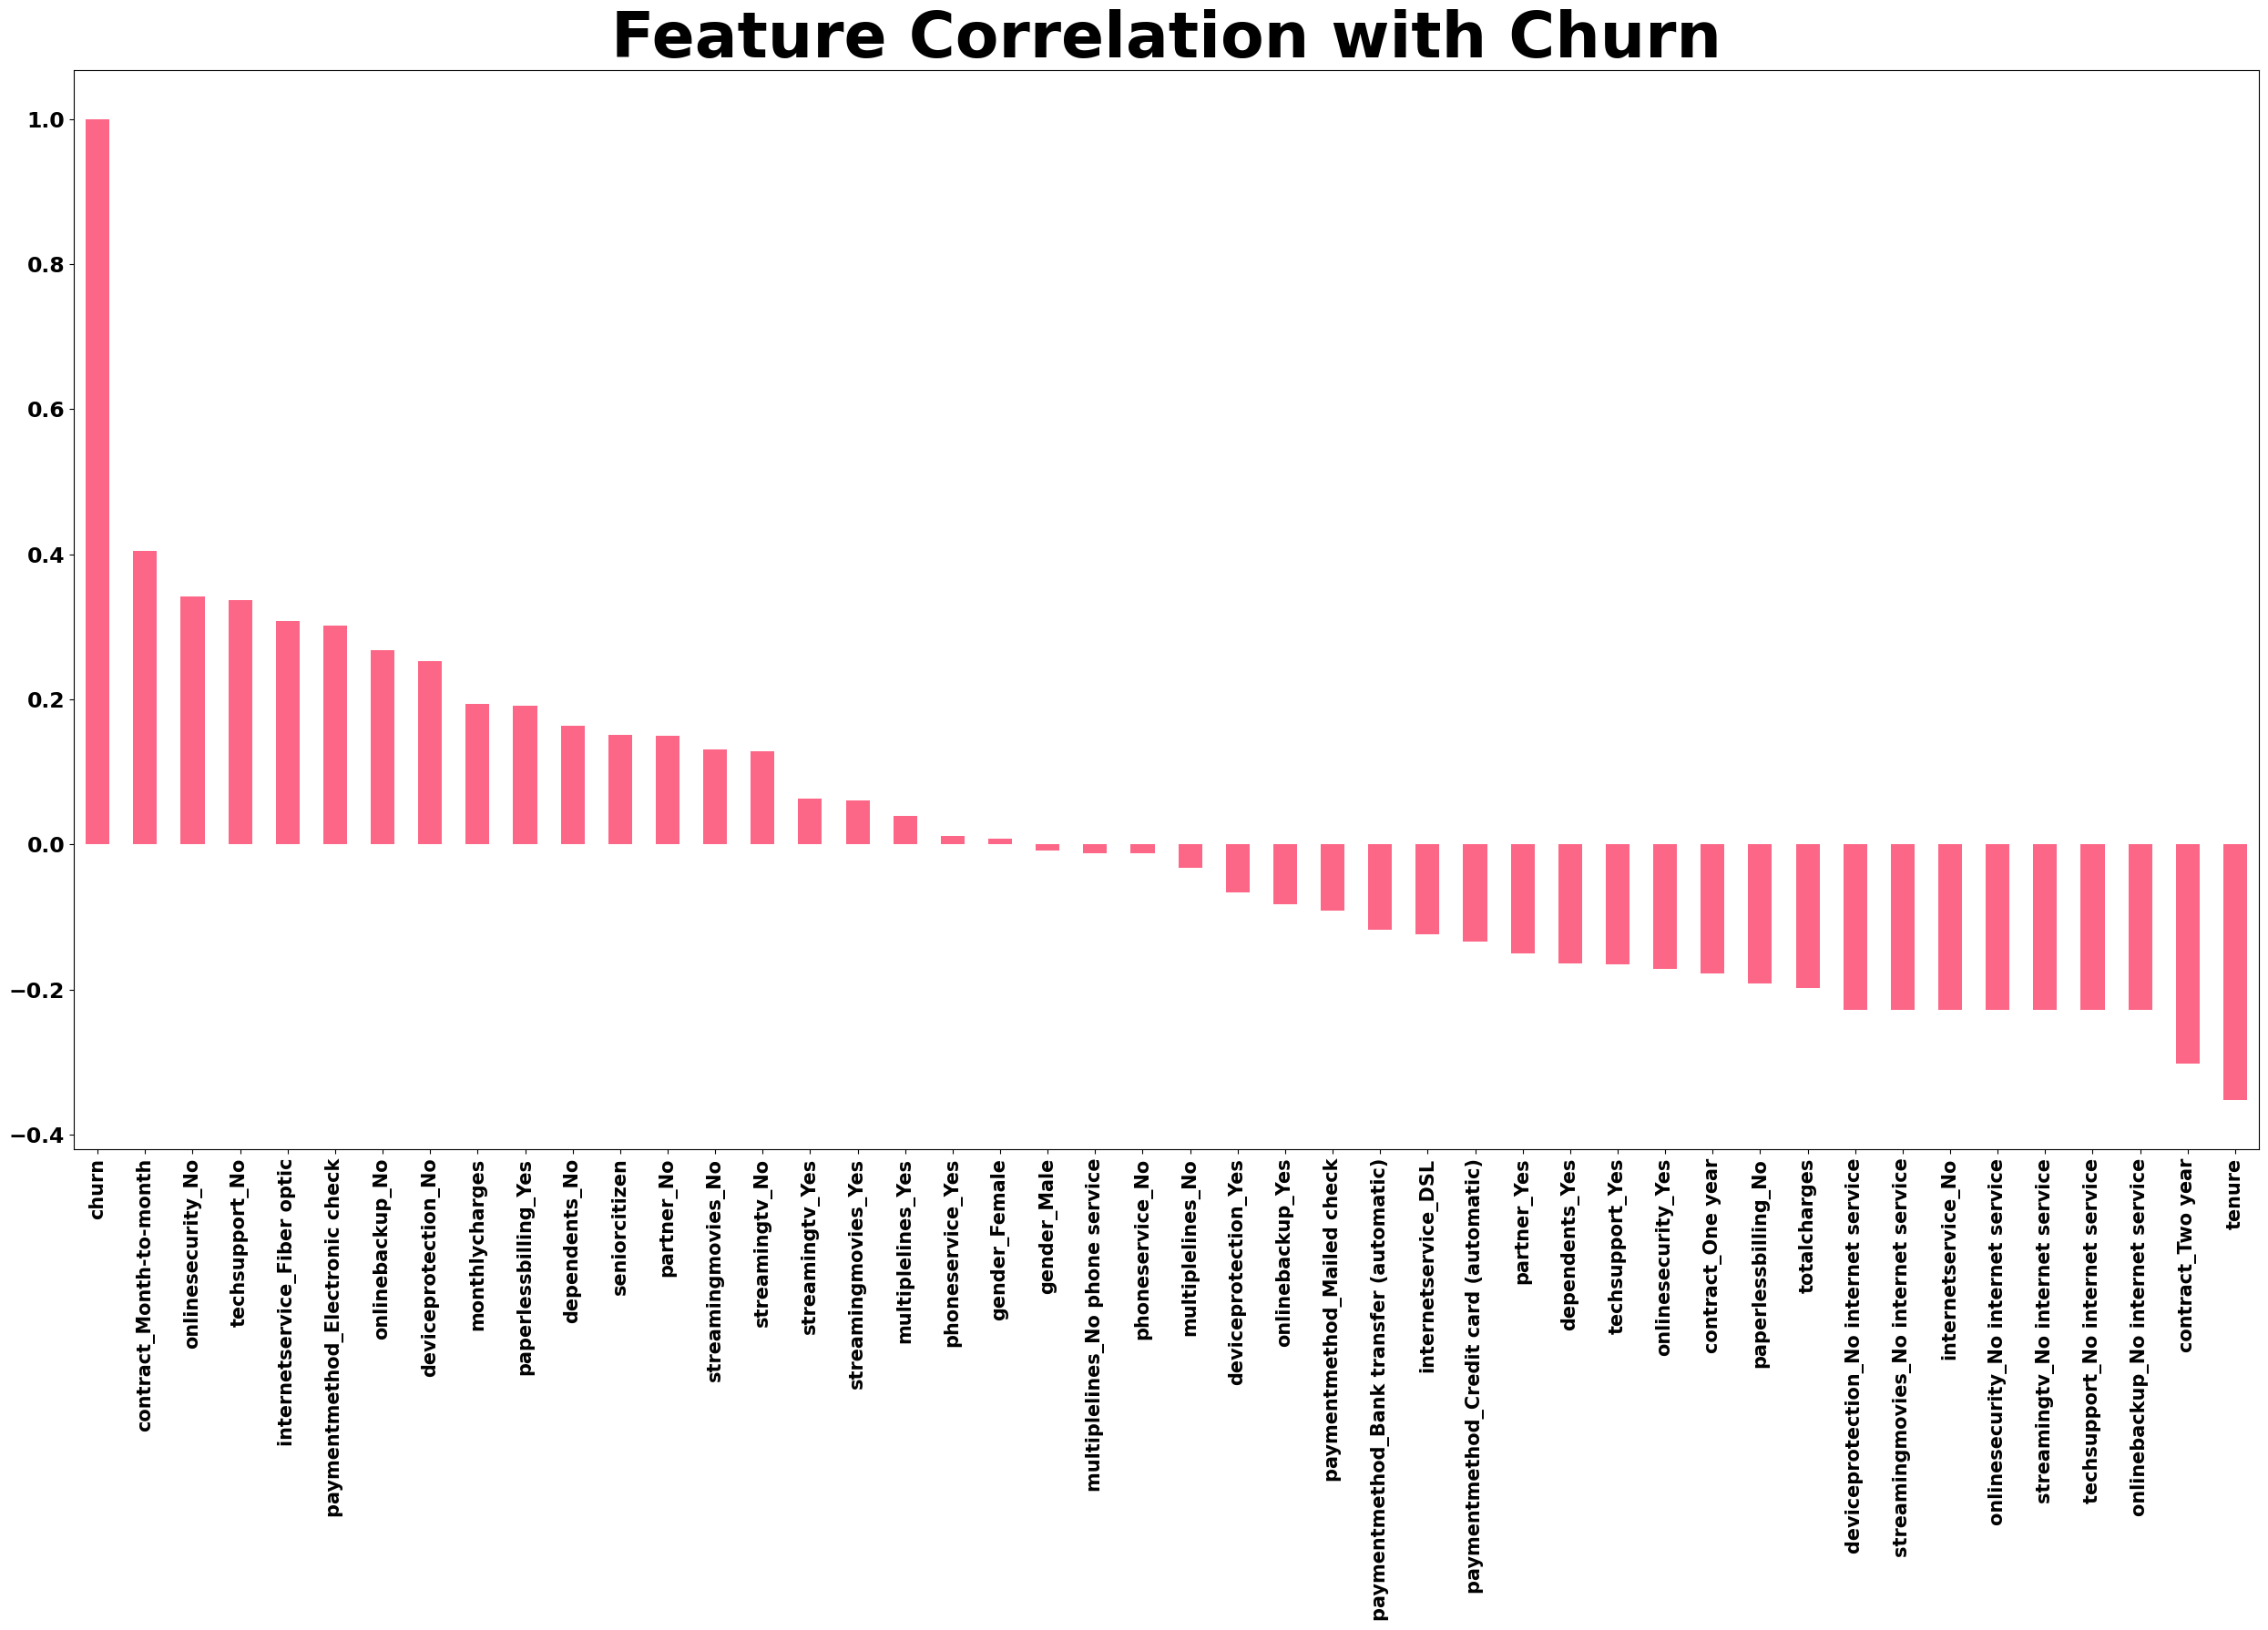

In [7]:
# Plot correlations between our features and our target feature, churn, as a bar plot, sort by descending order
dummy_cc.corr()['churn'].sort_values(ascending = False).plot(kind='bar', figsize = (25, 18), color = '#FD6787')
plt.title('Feature Correlation with Churn', fontsize = 50, fontweight = 'bold')
plt.xticks(fontsize = 15, fontweight = 'bold')
plt.yticks(fontweight = 'bold', fontsize = 17)
plt.tight_layout()

* Monthly contract, lacking online security, and lacking techsupport have the highest <i>positive</i> correlation with Churn.
* 2-year contract and not having internet service have the lowest <i>negative</i> correlation with Churn.

# <span style="color: green"> Pre-Processing Data for Logistic Regression

In [8]:
# establish target feature as y
y = dummy_cc.churn.values

In [9]:
# drop target feature from dataset
X = dummy_cc.drop('churn', axis =1)
# get a name list of dataframe columns titles
cols = X.columns

# <span style="color: green"> Scaling Data

In [10]:
#get minmax scaling object
mm = MinMaxScaler()
# fit and transform dataframe
X = pd.DataFrame(mm.fit_transform(X))
# reassign corresponding name for the new X
X.columns = cols

# <span style="color: green"> Splitting Train-Test

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25,random_state=30)

# <span style="color: green">Building the Model

In [12]:
# logistic regression model without an intercept.
LogReg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
# fit X_train and y_test into model
LogReg.fit(X_train,y_train)

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [13]:
# generate model prediction
y_hat_train = LogReg.predict(X_train)
y_hat_test = LogReg.predict(X_test)

# <span style="color: green"> Evaluating performance

### Classifier performance on Train set

In [14]:
# get residual difference between train data and predicted train data
res_dif = np.abs(y_train - y_hat_train)

print('Predicted train data value counts:')
print(pd.Series(res_dif).value_counts())
print('\nNormalized predicted train data value counts:')
print(pd.Series(res_dif).value_counts(normalize=True))


Predicted train data value counts:
0    4282
1    1000
dtype: int64

Normalized predicted train data value counts:
0    0.810678
1    0.189322
dtype: float64


### <b>Train set Results</b>
* 4282 correct - 1000 incorrect
* 81.06% accuracy

### Classifier performance on Test set

In [15]:
# get residual difference between train data and predicted train data
res_dif = np.abs(y_test - y_hat_test)

print('Predicted test data value counts:')
print(pd.Series(res_dif).value_counts())
print('\nNormalized predicted test data value counts:')
print(pd.Series(res_dif).value_counts(normalize=True))

Predicted test data value counts:
0    1394
1     367
dtype: int64

Normalized predicted test data value counts:
0    0.791596
1    0.208404
dtype: float64


### <b>Test Set Results</b>
* 1349 correct - 367 incorrect
* 79.1% accuracy

### Confusion Matrix

In [16]:
con_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n',con_matrix)

Confusion Matrix: 
 [[1122  131]
 [ 236  272]]


In [17]:
metrics(y_train,y_hat_train,y_test,y_hat_test)

Training Precision:  0.66016
Testing Precision:  0.67494


Training Recall:  0.54666
Testing Recall:  0.53543


Training Accuracy:  0.81068
Testing Accuracy:  0.7916


Training F1-score:  0.59807
Testing F1-score:  0.59715


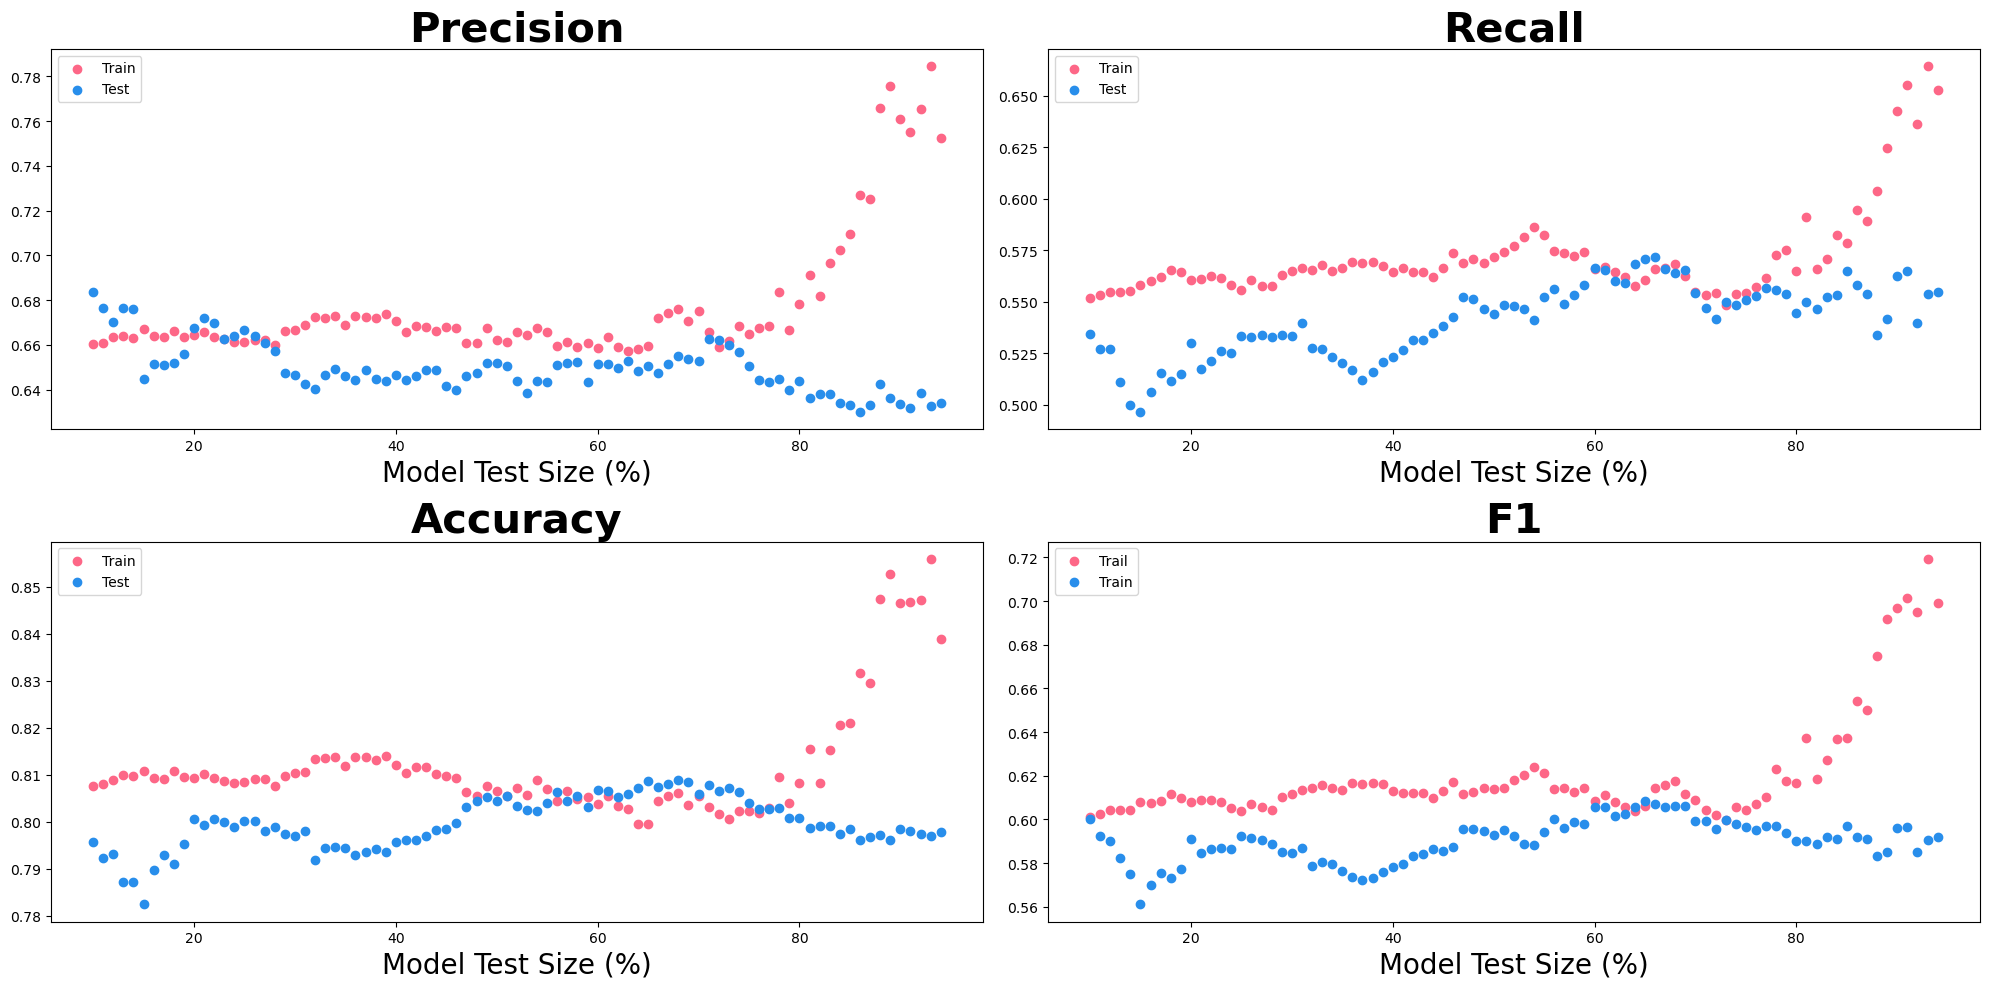

In [18]:
print_metric_comparisons(X, y)

### ROC Curves

Train AUC: 0.8511066562403201
Test AUC: 0.8398638543087141


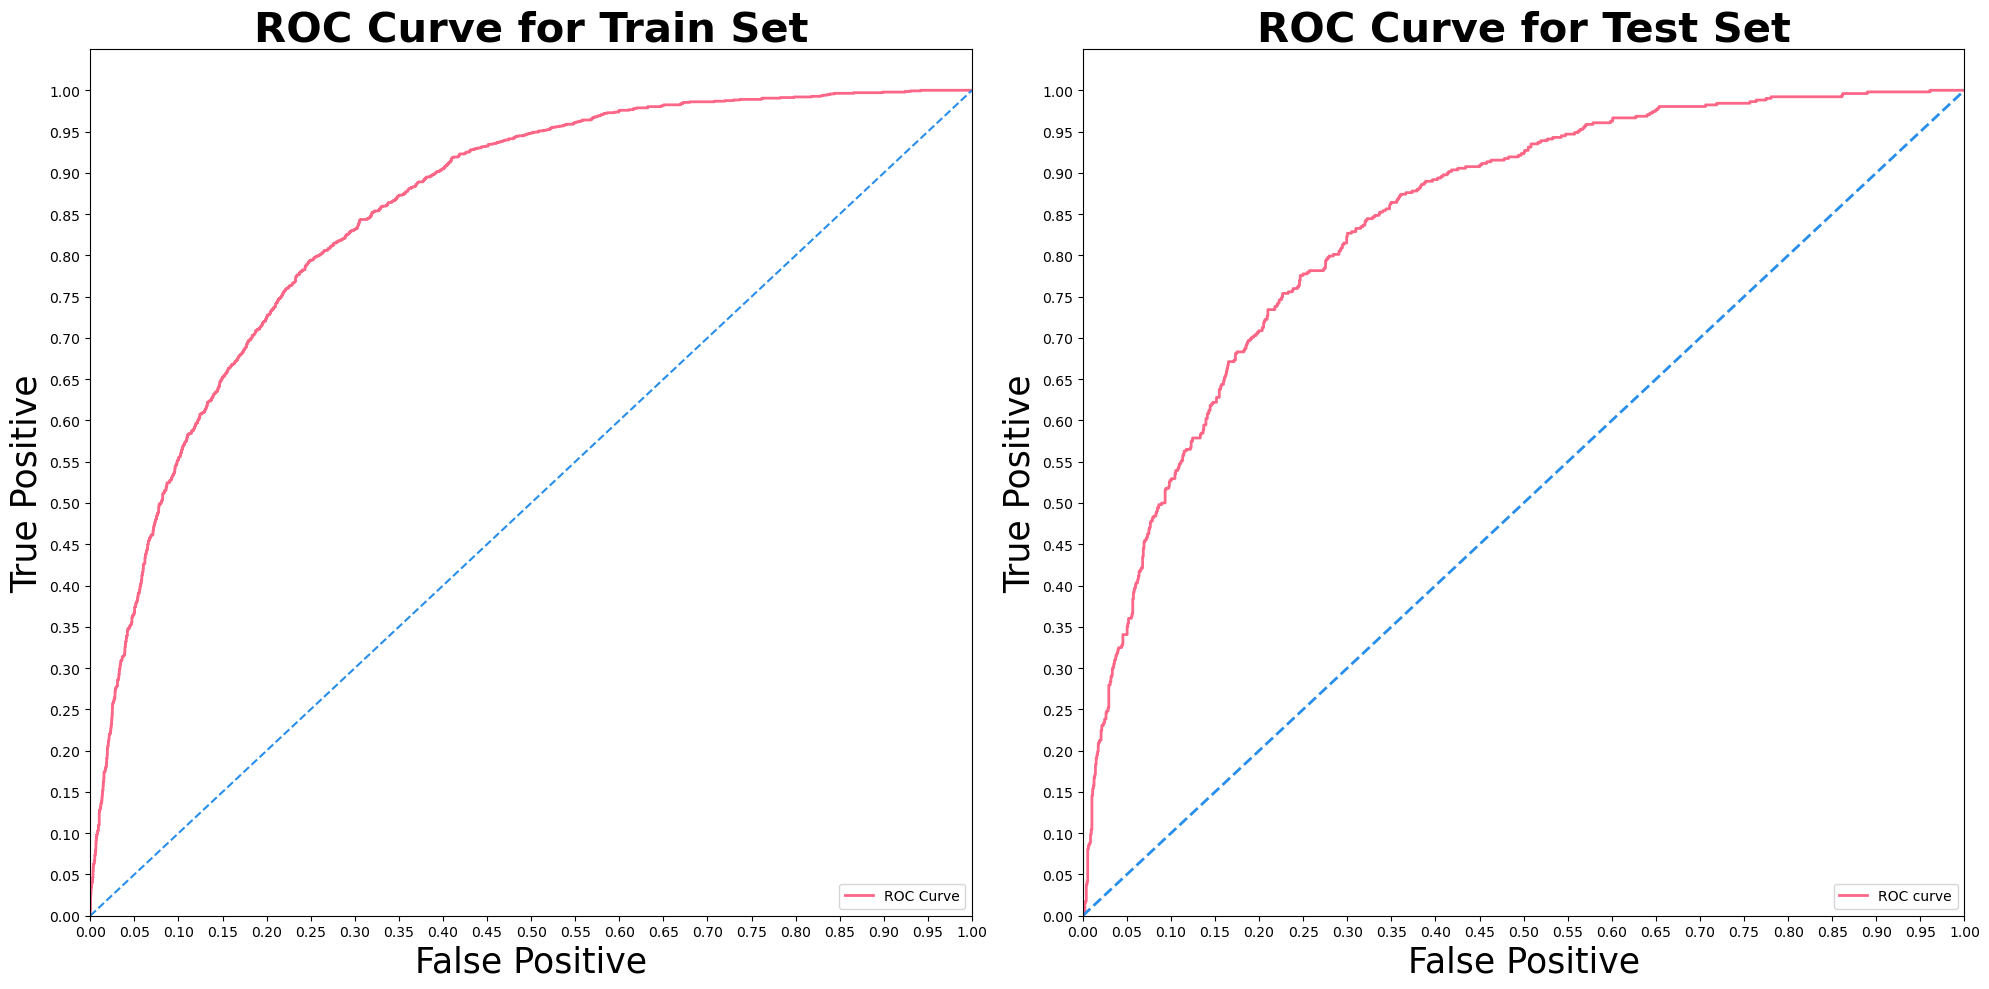

In [38]:
print_auc(LogReg,X_train,X_test,y_train,y_test)